# Resonator-Fluxonium Direct Dispersive Design

In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
from abc import abstractmethod, ABC
from functools import partial
from typing import List

from jax import jit, vmap, grad, device_get
from jax import config
from matplotlib.colors import LogNorm
from tqdm import tqdm
import jaxquantum as jqt
import jax.numpy as jnp
import scqubits as scq
from scqubits.utils.spectrum_utils import matrix_element as mel
import qutip as qt
import matplotlib.pyplot as plt 
import matplotlib as mpl
import numpy as np

from scipy import constants

from copy import deepcopy

config.update("jax_enable_x64", True)
jnp.set_printoptions(linewidth=jnp.inf)

import qcsys as qs
import time

# from helpers import *

In [24]:
def calculate_plasmon_heating_T1_limit(plasmon_freq, T, T1_plasmon):
    R = np.exp((constants.h * plasmon_freq * 1e9)/((constants.k * T)))
    Gamma_heating = 1/(R+1) * 1/T1_plasmon
    T1_heating = 1/Gamma_heating 
    return T1_heating

plasmon_freq = 3.27 #2.599236652043924 # [GHz], plasmon frequency
T = 0.040 # [K], temperature of the qubit
T1_plasmon =  20e3 # [ns], estimated lifetime of the plasmon transition (~ transmon lifetime)
T1_heating = calculate_plasmon_heating_T1_limit(plasmon_freq, T, T1_plasmon)
print("T1 limit from heating (ms): ", T1_heating*1e-6)

T1 limit from heating (ms):  1.0314229563957067


# SCQubits Simulations

### 1. Gen Functions

In [16]:
def calculate_storage_zpf(freq, impedance):
    expected_Z0 = impedance  # Ohms
    expected_E_L_over_E_C = (1 / (4 * expected_Z0)) ** 2 * (
        constants.h**2 / (8 * constants.e**4)
    )
    desired_E_C = jnp.sqrt(freq**2 / expected_E_L_over_E_C / 8)
    desired_E_L = freq**2 / desired_E_C / 8
    storage_q_zpf = (1 / 32 * desired_E_L / desired_E_C) ** (1 / 4)
    return storage_q_zpf, desired_E_C, desired_E_L

STORAGE_IMPEDANCE = 95.127
READOUT_IMPEDANCE = 49.674

In [17]:
""" Normal Split """
EJ = 3.754927
EC = 0.8440609445893907
EL = 0.29995365
w_s = 4.134 #- 50e-3
J_fs = 3e-3
w_r = 6.1

""" Other Split """;
# nominal_EC = 0.8440609445893907; nominal_EJ = 3.754927
# EC = 1.2 * nominal_EC
# EJ = 0.9 * nominal_EJ
# EL = 0.29995365
# w_s = 4.134
# J_fs = 5e-3 # INCREASED COUPLING to 5 MHz!!
# w_r = 6.1

In [18]:
nzpf_a = device_get(calculate_storage_zpf(w_s, STORAGE_IMPEDANCE)[0])
phi_zpf_a = device_get((2 * calculate_storage_zpf(w_s, STORAGE_IMPEDANCE)[1] / calculate_storage_zpf(w_s, STORAGE_IMPEDANCE)[2])**(1/4))
l_osc_a = np.sqrt(2) * phi_zpf_a

J_fr = 40e-3
nzpf_r = device_get(calculate_storage_zpf(w_r, READOUT_IMPEDANCE)[0])
phi_zpf_r = device_get((2 * calculate_storage_zpf(w_r, READOUT_IMPEDANCE)[1] / calculate_storage_zpf(w_r, READOUT_IMPEDANCE)[2])**(1/4))
l_osc_r = np.sqrt(2) * phi_zpf_r

In [19]:
def gen_fluxonium(φ):
    return scq.Fluxonium(EJ=EJ, EC=EC, EL=EL, flux=φ, cutoff=100, truncated_dim=15)

def gen_FS(φ):
    F = gen_fluxonium(φ)
    S = scq.Oscillator(E_osc=w_s, truncated_dim=8, l_osc=l_osc_a)

    hilb = scq.HilbertSpace([F, S])
    hilb.add_interaction(g=J_fs, op1=F.n_operator, op2=S.n_operator, add_hc=False)

    return hilb

def gen_FR(φ):
    F = gen_fluxonium(φ)
    R = scq.Oscillator(E_osc=w_r, truncated_dim=8, l_osc=l_osc_r)

    # g_fr = 70.0e-3 # fluxonium/readout coupling in weird units

    hilb = scq.HilbertSpace([F, R])
    # hilb.add_interaction(g=g_fr, op1=F.n_operator, op2=R.annihilation_operator, add_hc=True)
    hilb.add_interaction(g=J_fr, op1=F.n_operator, op2=R.n_operator, add_hc=False)

    return hilb

In [20]:
def scq_storage_chi_kerr(φ):
    """ 
    Function that calculates the fluxonium-storage χ and the inherited storage Kerr nonlinearities vs. external flux
    """

    hilb = gen_FS(φ)
    hilb.generate_lookup()

    χ = hilb.energy_by_bare_index((1, 1)) - hilb.energy_by_bare_index((1, 0)) - (hilb.energy_by_bare_index((0, 1)) - hilb.energy_by_bare_index((0, 0)))

    Kg = (hilb.energy_by_bare_index((0, 2)) - hilb.energy_by_bare_index((0, 1))) - (hilb.energy_by_bare_index((0, 1)) - hilb.energy_by_bare_index((0, 0)))
    Ke = (hilb.energy_by_bare_index((1, 2)) - hilb.energy_by_bare_index((1, 1))) - (hilb.energy_by_bare_index((1, 1)) - hilb.energy_by_bare_index((1, 0)))

    return χ, (Kg + Ke)/2, (Kg-Ke)/2

def scq_readout_chi_kerr(φ):
    """ 
    Function that calculates the fluxonium-readout χ vs. external flux
    """

    hilb = gen_FR(φ)
    hilb.generate_lookup()

    χ = hilb.energy_by_bare_index((1, 1)) - hilb.energy_by_bare_index((1, 0)) - (hilb.energy_by_bare_index((0, 1)) - hilb.energy_by_bare_index((0, 0)))

    Kg = (hilb.energy_by_bare_index((0, 2)) - hilb.energy_by_bare_index((0, 1))) - (hilb.energy_by_bare_index((0, 1)) - hilb.energy_by_bare_index((0, 0)))
    Ke = (hilb.energy_by_bare_index((1, 2)) - hilb.energy_by_bare_index((1, 1))) - (hilb.energy_by_bare_index((1, 1)) - hilb.energy_by_bare_index((1, 0)))

    return χ, (Kg + Ke)/2, (Kg-Ke)/2

def n_op_and_spectrum(φ):
    F = gen_fluxonium(φ)
    # Get eigen-energies and charge operator in the fluxonium eigenbasis
    evals_F, _ = F.eigensys(evals_count=F.truncated_dim)
    n = F.n_operator(energy_esys=True)

    return (evals_F, n)

def phi_op_and_spectrum(φ):
    F = gen_fluxonium(φ)
    # Get eigen-energies and charge operator in the fluxonium eigenbasis
    evals_F, _ = F.eigensys(evals_count=F.truncated_dim)
    phi = F.phi_operator(energy_esys=True)

    return (evals_F, phi)

def calc_matrix_elements(φ):
    hilb = gen_FR(φ)
    F, R = hilb.subsystem_list

    _, evecs_f = F.eigensys(evals_count=F.truncated_dim)
    _, evecs_r = R.eigensys(evals_count=R.truncated_dim)

    # We pass in φ and n as functions, and internally rotate them to their subsystem eigenbases before tensoring
    phi_q_bare = scq.identity_wrap(F.phi_operator, F, hilb.subsystem_list, op_in_eigenbasis=False, evecs=evecs_f)
    n_r_bare = scq.identity_wrap(R.n_operator, R, hilb.subsystem_list, op_in_eigenbasis=False, evecs=evecs_r)    
        
    hilb.generate_lookup()

    dressed_evals, dressed_evecs = hilb.eigensys(evals_count=7)

    idx_e0 = hilb.dressed_index((1, 0))
    idx_g1 = hilb.dressed_index((0, 1))

    e0 = dressed_evecs[idx_e0]
    g1 = dressed_evecs[idx_g1]


    return (mel(g1, n_r_bare, e0).item(),
            mel(g1, phi_q_bare, e0).item())

### 2. Plot Spectrum

In [168]:
def gradient_multiline_colorbar(parameters, discrete=True):
    # taken from https://stackoverflow.com/questions/26545897/drawing-a-colorbar-aside-a-line-plot-using-matplotlib/26562639#26562639
    diff = (
        [
            np.abs(parameters[1] - parameters[0]),
            np.abs(parameters[-1] - parameters[-2]),
        ]
        if discrete
        else [0, 0]
    )
    norm = mpl.colors.Normalize(
        vmin=np.min(parameters) - diff[0] / 2, vmax=np.max(parameters) + diff[1] / 2
    )
    c_m = (
        mpl.cm.plasma_r
        if not discrete
        else plt.get_cmap("plasma_r", int(np.max(parameters) - np.min(parameters) + 1))
    )
    cmap = mpl.cm.ScalarMappable(cmap=c_m, norm=norm)
    cmap.set_array([])
    return cmap


def plot_multiline_gradient(x, ys, levels, fig=None, ax=None, discrete=True):
    cmap = gradient_multiline_colorbar(levels, discrete=discrete)
    fig = fig if fig is not None else plt.figure(figsize=(4, 3), dpi=200)
    ax = ax if ax is not None else fig.subplots()

    for i, line in enumerate(ys):
        level = levels[i]
        color = cmap.to_rgba(level)
        ax.plot(x, np.real(line), color=color)

    cbar = plt.colorbar(cmap, ax=ax, ticks=levels)
    cbar.ax.tick_params(labelsize=8)
    return fig, ax, cbar

def plot_transitions(phi_exts, Es, charge_elements, fig=None, axs=None):
    # phi_exts = jnp.array([data[j]["params"]["phi_ext"] for j in data.keys()])
    # Es = jnp.array([data[j]["results"]["metrics"]["E"] for j in data.keys()])
    # n_op = jnp.array([data[j]["results"]["metrics"]["n_op"] for j in data.keys()])

    # return Es, n_op

    transitions_from = {
        "g": (Es.T - np.atleast_2d(Es[:, 0])),
        "e": (Es.T - np.atleast_2d(Es[:, 1])),
    }
    start_lvls = ["g", "e"]

    
    if fig is None or axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(8, 3), dpi=200)

    charge_norm = np.max(np.abs(charge_elements[:, :, 0]))
    for i, start_lvl in enumerate(start_lvls):
        cmap = gradient_multiline_colorbar(
            np.abs(charge_elements[:, :, 0]) / charge_norm, discrete=False
        )
        cbar = plt.colorbar(cmap, ax=axs[i])
        cbar.ax.tick_params(labelsize=9)
        cbar.ax.set_title(
            f"|$\\langle m | \hat n | {start_lvl}\\rangle$|",
            rotation=0,
            size=9,
        )
        cbar.ax.set_yticks([0, 1])

        for ldx, line in enumerate(transitions_from[start_lvl]):
            axs[i].scatter(
                phi_exts,
                np.real(line),
                c=cmap.to_rgba(np.abs(charge_elements[:, ldx, i]) / charge_norm),
                s=2,
            )
    for i, ax in enumerate(axs):
        plt.sca(ax)
        ax.set_title(fr"Transitions between $|{start_lvls[i]}\rangle$ to $|n\rangle$", size=11)
        ax.set_xlabel(r"$\Phi_{\rm ext}/\Phi_0$", fontsize=11)
        ax.set_xlim(phi_exts[0], phi_exts[-1])
        ax.set_ylabel(r"$\Delta$E (GHz)", fontsize=11)
        # if not color_with_charge:
        #     ax.legend(loc="upper right", prop={"size": 6})
    # plt.tight_layout()
    return fig, axs

In [164]:
φ_exts_spectrum = np.linspace(0.36, 0.5, 201)
n_and_s = [n_op_and_spectrum(f) for f in φ_exts_spectrum]

Es = np.array([n[0] for n in n_and_s])
ns = np.array([n[1] for n in n_and_s])
# phis = np.array([phi_op_and_spectrum(f)[1] for f in φ_exts_spectrum])

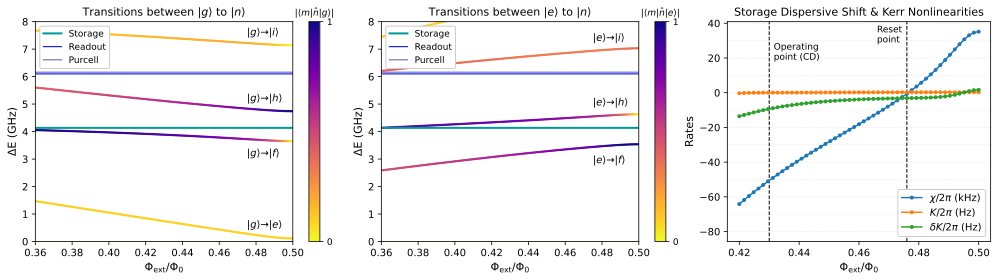

In [185]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4), dpi=300, gridspec_kw={"width_ratios": [1.1, 1.1, 0.9]})

plot_transitions(φ_exts_spectrum, Es, ns, fig=fig, axs=axs[:2])

for a in axs[:2]:
    plt.sca(a)
    plt.axhline(y=w_s, xmin=0.0, xmax=1.0, ls='-', linewidth=2, color='#009999', label="Storage")
    plt.axhline(y=6.1, xmin=0.0, xmax=1.0, ls='-', linewidth=1.2, color='#1923fc', label="Readout")
    plt.axhline(y=6.16, xmin=0.0, xmax=1.0, ls='-', linewidth=1.2, color='#7376b9', label="Purcell")
    plt.ylim(0, 8)

    # Whiten out the zero transition
    a.plot(φ_exts_spectrum, np.zeros_like(φ_exts_spectrum), c='white', lw=3)
    a.legend(loc="upper left", fontsize=9, framealpha=1)


axs[0].text(0.475, 0.5, r"$|g\rangle \to |e\rangle$", fontsize=10)
axs[0].text(0.475, 3.1, r"$|g\rangle \to |f\rangle$", fontsize=10)
axs[0].text(0.475, 5.1, r"$|g\rangle \to |h\rangle$", fontsize=10)
axs[0].text(0.475, 7.5, r"$|g\rangle \to |i\rangle$", fontsize=10)

axs[1].text(0.475, 2.85, r"$|e\rangle \to |f\rangle$", fontsize=10)
axs[1].text(0.475, 4.95, r"$|e\rangle \to |h\rangle$", fontsize=10)
axs[1].text(0.475, 7.3, r"$|e\rangle \to |i\rangle$", fontsize=10)


axs[2].plot(φ_exts_fs, scq_chi_kerrs[:, 0] * 1e6, '.-', label = r'$\chi/2\pi$ (kHz)')
axs[2].plot(φ_exts_fs, scq_chi_kerrs[:, 1] * 1e9, '.-', label = r'$K/2\pi$ (Hz)')
axs[2].plot(φ_exts_fs, scq_chi_kerrs[:, 2] * 1e9, '.-', label = r'$\delta K/2\pi$ (Hz)')
min_ylim = -80; max_ylim = 45
for ylim in range(min_ylim, max_ylim, 10):
    axs[2].axhline(ylim, c='lightgrey', ls='dotted', lw=0.5, zorder=-1)   

axs[2].set_xlabel(r"$\Phi_{\rm ext}/\Phi_0$", fontsize=11)
axs[2].set_ylabel(r"Rates", fontsize=11) 
axs[2].legend(fontsize=10, loc="lower right", framealpha=1)
axs[2].set_title("Storage Dispersive Shift & Kerr Nonlinearities", size=11)
axs[2].axvline(0.476, c='k', ls='--', lw=1, zorder=-1, label="Reset point")
axs[2].axvline(0.43, c='k', ls='--', lw=1, zorder=-1, label="CD point")
axs[2].text(0.466, 29, "Reset \npoint", fontsize=9)
axs[2].text(0.4315, 19, "Operating\npoint (CD)", fontsize=9)

plt.tight_layout()
plt.subplots_adjust(wspace=0.08)

plt.savefig("2D_dispersive_metrics.pdf", bbox_inches='tight')

In [ ]:
def calculate_plasmon_heating_T1_limit(plasmon_freq, T, T1_plasmon):
    R = np.exp((constants.h * plasmon_freq * 1e9)/((constants.k * T)))
    Gamma_heating = 1/(R+1) * 1/T1_plasmon
    T1_heating = 1/Gamma_heating 
    return T1_heating

plasmon_freq = 2.896 #2.599236652043924 # [GHz], plasmon frequency
T = 0.040 # [K], temperature of the qubit
T1_plasmon =  20e3 # [ns], estimated lifetime of the plasmon transition (~ transmon lifetime)
T1_heating = calculate_plasmon_heating_T1_limit(plasmon_freq, T, T1_plasmon)
print("T1 limit from heating (ms): ", T1_heating*1e-6)

### 2. Storage Chi and Kerr

In [44]:
φ_exts_fs = np.linspace(0.42, 0.5, 51)
scq_chi_kerrs = np.array([scq_storage_chi_kerr(phi) for phi in φ_exts_fs])

In [45]:
np.where(np.isclose(φ_exts_fs, 0.43))

(array([], dtype=int64),)

In [46]:
scq_chi_kerrs[15, 1] * 1e9

0.10248157877867925

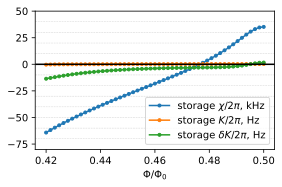

In [47]:
# plt.figure(figsize=(4, 3.6))
plt.figure(figsize=(4.3, 2.5), dpi=200)

plt.plot(φ_exts_fs, scq_chi_kerrs[:, 0] * 1e6, '.-', label = r'storage $\chi/2\pi$, kHz')
plt.plot(φ_exts_fs, scq_chi_kerrs[:, 1] * 1e9, '.-', label = r'storage $K/2\pi$, Hz')
plt.plot(φ_exts_fs, scq_chi_kerrs[:, 2] * 1e9, '.-', label = r'storage $\delta K/2\pi$, Hz')
# plt.axhline(y = 0.0, color = 'k', ls='--', lw=1)

# plt.plot(phi_exts_plot, chi_plot[:, 0] * 1e6, '.-.')
# plt.plot(phi_exts_plot, K_avg_plot[:, 0]  * 1e9, '.-.')
# plt.plot(phi_exts_plot, dK_plot[:, 0]  * 1e9, '.-.')


# plt.axvline(x = 0.426, color = 'k', ls='--', lw=1, label="Proposed Op. Point: 0.426")

# plt.title(fr"(${EC / split_EC:.1f}E_C$, ${EJ / split_EJ:.1f}E_J$)", fontsize=20)

min_ylim = -80; max_ylim = 45
for ylim in range(min_ylim, max_ylim, 10):
    plt.axhline(ylim, c='lightgrey', ls='--', lw=0.5, zorder=-1)    

plt.xlabel(r"$\Phi/\Phi_0$")
# plt.ylabel(r"Rates")
plt.ylim(-80, 50)
# plt.xlim(0.4, 0.5)
plt.axhline(0, c='k')
# plt.axvline(0.476, c='k', lw=1, zorder=-1, label="chi off")
plt.legend(fontsize=10, loc="lower right")


In [ ]:
def split_plotter(split_EC, split_EJ):

    """ Metrics Functions """
    def sweep_gen_fluxonium(φ, EC, EJ):
        return scq.Fluxonium(EJ=EJ, EC=EC, EL=EL, flux=φ, cutoff=100, truncated_dim=15)

    def sweep_gen_FS(φ, EC, EJ):
        F = sweep_gen_fluxonium(φ, EC, EJ)
        S = scq.Oscillator(E_osc=w_s, truncated_dim=8, l_osc=l_osc_a)
        hilb = scq.HilbertSpace([F, S])
        hilb.add_interaction(g=J_fs, op1=F.n_operator, op2=S.n_operator, add_hc=False)
        return hilb

    def sweep_scq_storage_chi_kerr(φ, EC, EJ):
        hilb = sweep_gen_FS(φ, EC, EJ)
        hilb.generate_lookup()
        χ = hilb.energy_by_bare_index((1, 1)) - hilb.energy_by_bare_index((1, 0)) - (hilb.energy_by_bare_index((0, 1)) - hilb.energy_by_bare_index((0, 0)))
        Kg = (hilb.energy_by_bare_index((0, 2)) - hilb.energy_by_bare_index((0, 1))) - (hilb.energy_by_bare_index((0, 1)) - hilb.energy_by_bare_index((0, 0)))
        Ke = (hilb.energy_by_bare_index((1, 2)) - hilb.energy_by_bare_index((1, 1))) - (hilb.energy_by_bare_index((1, 1)) - hilb.energy_by_bare_index((1, 0)))
        return χ, (Kg + Ke)/2, (Kg-Ke)/2
    
    
    """ Calculate and Plot """
    targets = np.array([0.9, 1, 1.1])

    fig, axs = plt.subplots(3, 3, dpi=150, figsize = (8.5, 6.5))

    for i, EC_factor in enumerate(targets):
        for j, EJ_factor in enumerate(targets):

            EC = split_EC * EC_factor
            EJ = split_EJ * EJ_factor

            scq_chi_kerrs = np.array([sweep_scq_storage_chi_kerr(phi, EC, EJ) for phi in φ_exts_fs])


            f_evs_half_flux = sweep_gen_fluxonium(0.5, EC, EJ).eigenvals()
            f_evs_op = sweep_gen_fluxonium(0.426, EC, EJ).eigenvals()
            print(i+1, j+1, f"{(f_evs_half_flux[1]-f_evs_half_flux[0])*1e3:.2f}", f"{(f_evs_op[2]-f_evs_op[1]):.2f}")
            
            
            axs[i, j].set_title(fr"(${EC_factor:.1f}E_C$, ${EJ_factor:.1f}E_J$)", fontsize=15)
            axs[i, j].plot(φ_exts_fs, scq_chi_kerrs[:, 0] * 1e6, '.-', label = r'storage $\chi/2\pi$, kHz')
            axs[i, j].plot(φ_exts_fs, scq_chi_kerrs[:, 1] * 1e9, '.-', label = r'storage $K/2\pi$, Hz')
            axs[i, j].plot(φ_exts_fs, scq_chi_kerrs[:, 2] * 1e9, '.-', label = r'storage $\delta K/2\pi$, Hz')
            axs[i, j].set_xlim(0.4, 0.5)
            axs[i, j].set_xlabel(r"$\varphi_{\rm ext}$")
            axs[i, j].axhline(0, c='k')
            axs[i, j].axhline(-50, c='k', lw=0.5)

            min_ylim = -80; max_ylim = 85
            axs[i, j].set_ylim(min_ylim, max_ylim)

            for ylim in range(min_ylim, max_ylim, 10):
                axs[i, j].axhline(ylim, c='lightgrey', ls='--', lw=0.5, zorder=-1)            


    plt.legend(fontsize=7.5)
    plt.tight_layout()
    
    

In [ ]:
split_plotter(nominal_EC, nominal_EJ)

In [ ]:
10**-0.2 / 16

### 3. Readout Chi and Kerr 

In [ ]:
φ_exts_fr = np.linspace(0.4, 0.5, 101)
scq_readout_chis = np.array([scq_readout_chi_kerr(phi) for phi in φ_exts_fr])

In [ ]:
plt.plot(φ_exts_fr, scq_readout_chis[:, 0] * 1e3, '.-', label = r'storage $\chi/2\pi$, MHz')
plt.plot(φ_exts_fr, scq_readout_chis[:, 1] * 1e6, '.-', label = r'storage $K/2\pi$, kHz')
plt.plot(φ_exts_fr, scq_readout_chis[:, 2] * 1e6, '.-', label = r'storage $\delta K/2\pi$, kHz')
plt.axhline(y = 0.0, color = 'k', ls='--', lw=1)
plt.axhline(y = -1, color = 'k', ls='--', lw=1)

plt.xlabel(r"$\Phi/\Phi_0$")
plt.ylim(-10, 1)
# plt.xlim(0.42, 0.5)
plt.legend()


In [ ]:
melz3 = np.array([calc_matrix_elements(f) for f in φ_exts_fr])

In [ ]:
plt.figure(figsize=(4, 2), dpi=200)

# plt.plot(φ_exts_fr, 3*np.abs(melz3[:, 0]), label=r"$|\langle g1|n_r|e0\rangle|$")
plt.plot(φ_exts_fr, 2*np.abs(melz3[:, 1]), label=r"$|\langle g1|\,\hat{\varphi}_q\,|e0\rangle|$", lw=2)
plt.legend(loc="upper right", framealpha=1)
plt.ylim(-1e-3)

plt.xlabel(r"Ext. Flux $\varphi_{\rm ext}/2\pi$")
plt.ylabel(r"Matrix Element")